**1**. (100 points)

Implement the Drossel and Schwabl forest fire model using the [description](https://en.wikipedia.org/wiki/Forest-fire_model#/media/File:Forest_fire_model.gif) from Wikipedia. Your final solution should be similar to the video `forest_fire.mp4` in the homework folder.

```
The model is defined as a cellular automaton on a grid with Ld cells. L is the sidelength of the grid and d is its dimension. A cell can be empty, occupied by a tree, or burning. The model of Drossel and Schwabl (1992) is defined by four rules which are executed simultaneously:
A burning cell turns into an empty cell
A tree will burn if at least one neighbor is burning
A tree ignites with probability f even if no neighbor is burning
An empty space fills with a tree with probability p
```

- Parameters for the simulation are
```python
steps = 200  # Number of steps
p = 0.03     # Probability of EMPTY -> TREE
f = p * 0.01 # Probability of TREE -> FIRE
n = 200      # Length of square grid
steps = 200  # Number of simulation steps
```
- You need to write code create an array named `sim` with shape (steps, n, n)
- **Note**: Your code should make use of `numpy` optimizations as much as possible - the simulation itself takes less than a second to complete on my fairly old desktop
- Now create a plot as shown from the `sims` array
![](data/forest_fire.png)
- Code to display an animation of the `sims` array is provided
- Your animation should be similar to the one shown

Hints:

- For simplicity, assume that the borders of the simulation grid are fixed so they are always empty (the borders are *outside* the 100 by 100 grid you are saving at each step.
- Use marginalization to get the required numbers for the plot of population sizes over time
- Use *views* liberally - they do not incur the cost of a copy


In [111]:
from IPython.display import Video

Video("data/forest_fire.mp4")

In [112]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
import numpy.ma as ma
np.random.seed(123)

In [113]:
EMPTY, TREE, BURN = 0, 1, 2

In [114]:
steps = 200  # Number of steps
p = 0.03     # Probability of EMPTY -> TREE
f = p * 0.01 # Probability of TREE -> FIRE
n = 200      # Length of square grid

*Perform simulation.* 

*On my computer, it takes ~1.08s for my code to run, which I understand is not ideal. I would appreciate any feedback on how to implement this process more efficiently.*

In [115]:
%%time

# Initialize array
sim = np.zeros((steps, n + 2, n + 2), dtype = 'float')

# Iterate through each step, starting at the 2nd step
for step in range(1, steps):
    
    # Start each step by carrying over the trees from the previous step
    sim[step, sim[step - 1, :, :] == TREE] = TREE
    
    # Set trees on fire if at least one neighbor is burning (including diagonal neighbors)
    mask_tree = sim[step, 1:-1, 1:-1] != TREE
    top = sim[step - 1, :-2, 1:-1]
    bottom = sim[step - 1, 2:, 1:-1]
    left = sim[step - 1, 1:-1, :-2]
    right = sim[step - 1, 1:-1, 2:]
    topleft = sim[step - 1, :-2, :-2]
    topright = sim[step - 1, :-2, 2:]
    bottomleft = sim[step - 1, 2:, :-2]
    bottomright = sim[step - 1, 2:, 2:]
    sim[step, 1:-1, 1:-1] = (ma.masked_array(sim[step, 1:-1, 1:-1], mask_tree) + 
                     np.any(np.dstack([left, right, bottom, top, topleft, topright,
                                      bottomleft, bottomright]) == 2, axis = -1)).data
    
    # Set some trees on fire at random. For this step, it is slightly quicker not to use a mask
    sim[step, sim[step, :, :] == TREE] += np.random.binomial(n = 1, size = (sim[step, :, :] == TREE).sum(), p = f)
    
    # Plant some trees at random. For this step, it is slightly quicker to use a mask
    mask_empty = sim[step, 1:-1, 1:-1] != EMPTY
    sim[step, 1:-1, 1:-1] = (ma.masked_array(sim[step, 1:-1, 1:-1], mask_empty) +
                     np.random.binomial(n = 1, size = (n, n), p = p)).data

CPU times: user 1.06 s, sys: 56 ms, total: 1.11 s
Wall time: 1.11 s


*Create plot to match forest_fire.png*

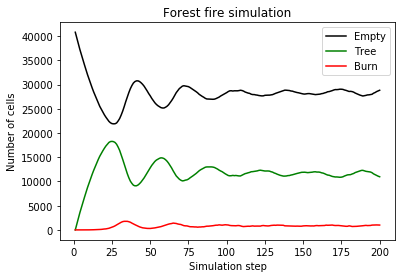

In [116]:
# Determine number of empty, tree, and burning cells at each step
empty = np.sum(sim == EMPTY, axis = (1, 2))
tree = np.sum(sim == TREE, axis = (1, 2))
burn = np.sum(sim == BURN, axis = (1, 2))
sim_num = np.arange(1, 201)

# Plot result
plt.plot(sim_num, empty, color = 'black', label = 'Empty')
plt.plot(sim_num, tree, color = 'green', label = 'Tree')
plt.plot(sim_num, burn, color = 'red', label = 'Burn')
plt.title('Forest fire simulation')
plt.xlabel('Simulation step')
plt.ylabel('Number of cells')
plt.legend()
pass

# Check movie

If your `sim` array is correct, the animation will play upon execution. It takes a bit of time (< 1 minute) to genreate the animation and render to HTML.

In [117]:
%%capture

fig = plt.figure(figsize=(6,6))
im = plt.imshow(sim[0], cmap=ListedColormap(['black', 'green', 'red']), vmin=0, vmax=2)

def updatefig(j):
    im.set_array(sim[j])
    return [im]

ani = animation.FuncAnimation(fig, updatefig, frames=range(steps), 
                              interval=50, blit=True);

In [118]:
%%time

HTML(ani.to_jshtml())

CPU times: user 17.4 s, sys: 188 ms, total: 17.6 s
Wall time: 17.6 s


To write to file if you have ffmpeg instaled

```python 
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('forest_fire.mp4', writer=writer)
```